In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
#you will have to pip install extra_keras_datasets
from extra_keras_datasets import emnist
import numpy as np

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [2]:
import PIL
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage import color
from PIL import Image
import pandas as pd

In [3]:
#byclass does uppercase, lowercase, and digits
(x_train, y_train), (x_test, y_test) = emnist.load_data(type = 'byclass')

num_train = len(x_train) // 3
num_test = len(x_test) // 2

valid_labels = list(range(10,62))
train_mask = np.isin(y_train, valid_labels)
test_mask = np.isin(y_test, valid_labels)

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]


x_train, y_train = x_train[:num_train], y_train[:num_train]
x_test, y_test = x_test[:num_test], y_test[:num_test]

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

INFO:root:Loading dataset = emnist


In [4]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.batch_norm1 = BatchNormalization()
        #self.dropout1 = Dropout(0.25)
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))
        self.batch_norm2 = BatchNormalization()
        #self.dropout2 = Dropout(0.5)
        #10 in digits, 62 in byclass
        self.d2 = Dense(62, activation='softmax',kernel_regularizer=regularizers.l2(0.01))

    def call(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        #x = self.dropout1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.batch_norm2(x)
        #x = self.dropout2(x)
        return self.d2(x)

In [5]:
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')

In [6]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [7]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [8]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))

Epoch 1, Loss: 0.6326807141304016, Accuracy: 79.58168029785156, Test Loss: 0.49696922302246094, Test Accuracy: 83.11067962646484
Epoch 2, Loss: 0.45093977451324463, Accuracy: 84.04386138916016, Test Loss: 0.47372791171073914, Test Accuracy: 83.85343933105469
Epoch 3, Loss: 0.3904116153717041, Accuracy: 85.59300994873047, Test Loss: 0.4783876836299896, Test Accuracy: 83.6024169921875
Epoch 4, Loss: 0.3349608778953552, Accuracy: 87.22039031982422, Test Loss: 0.5198637247085571, Test Accuracy: 83.17085266113281
Epoch 5, Loss: 0.28489384055137634, Accuracy: 88.88430786132812, Test Loss: 0.5798599720001221, Test Accuracy: 82.29397583007812


In [9]:
tf.keras.models.save_model(model, './LETTERMODEL')

INFO:tensorflow:Assets written to: ./LETTERMODEL\assets


INFO:tensorflow:Assets written to: ./LETTERMODEL\assets


In [10]:
image = Image.open('/Users/jackl/Documents/AIPRAC/enigma-ocr/Test Data/1.png')
#This resizes the image to the size it needs to be
image = image.resize((28, 28), resample=Image.BILINEAR)
image = np.asarray(image)
image = color.rgb2gray(image)

#dimension stuff
image = np.expand_dims(image, axis=-1)
image = np.expand_dims(image, axis=0)
y_pred = model.predict(image)

1/1 [==============================] - 0s 101ms/step


In [11]:
def predDict(num):
  df = pd.read_excel("./Dictionary.xlsx", sheet_name=0)
  data_dict = dict(zip(df['Numbers'], df['Symbols']))
  return data_dict[num]

In [12]:
y_pred_class = np.argmax(y_pred, axis=-1)
predDict(y_pred_class[0])

'I'

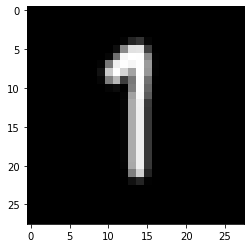

In [13]:
plt.imshow(np.squeeze(image),cmap='gray')
